# Layer Extension

In this example, we will demonstrate how to extend layers in data re-uploading circuits and making a more powerful DARUAN in QKAN.

In [1]:
import matplotlib.pyplot as plt
import torch

from qkan import QKAN, create_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

# f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)
dataset = create_dataset(f, n_var=2, device=device)

# initialize QKAN with r=1
model = QKAN(
    [2, 5, 1],
    reps=1,
    device=device,
    preact_trainable=True,  # enable flexible fourier frequency
    postact_bias_trainable=True,  # extend output bound
    postact_weight_trainable=True,  # extend output bound
    ba_trainable=True,  # enable residual connection for better convergence
)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3) 

In [2]:
test_results = []
qkans = [model]  # save the model

In [3]:
result = model.train_(dataset, optimizer=optimizer, steps=100)
test_results += result["test_loss"]

100%|█████████████████| 100/100 [00:00<00:00, 181.69it/s, train loss=1.0124128, test loss=1.1017513]


Do layer extension to get a fine-grained model.

In [4]:
reps = [5 * i for i in range(1, 5)]
for idx, r in enumerate(reps):
    qkans.append(
        QKAN(
            [2, 5, 1],
            reps=r,
            device=device,
            preact_trainable=True,
            postact_bias_trainable=True,
            postact_weight_trainable=True,
            ba_trainable=True,
        )
    )
    qkans[-1].initialize_from_another_model(qkans[idx])
    optimizer = torch.optim.LBFGS(qkans[-1].parameters(), lr=5e-1)
    result = qkans[-1].train_(dataset, optimizer=optimizer, steps=100)
    test_results += result["test_loss"]

100%|████████████| 100/100 [00:03<00:00, 28.59it/s, train loss=9.314607e-08, test loss=1.240494e-07]


Compare to directly train a large number of repetitions.

In [5]:
model = QKAN(
    [2, 5, 1],
    reps=20,
    device=device,
    preact_trainable=True,
    postact_bias_trainable=True,
    postact_weight_trainable=True,
    ba_trainable=True,
)
optimizer = torch.optim.LBFGS(model.parameters(), lr=5e-1)
result = model.train_(dataset, optimizer=optimizer, steps=500)

100%|███████████| 500/500 [00:49<00:00, 10.07it/s, train loss=4.4905502e-07, test loss=7.657976e-07]


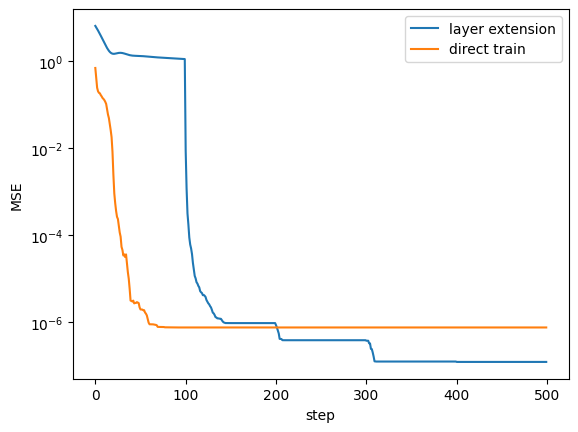

In [6]:
plt.plot(test_results, label="layer extension")
plt.plot(result["test_loss"], label="direct train")
plt.ylabel("MSE")
plt.xlabel("step")
plt.yscale("log")
plt.legend()

With layer extension, the model achieves better loss performance while requiring less training time, enabling efficient scalability without sacrificing accuracy.